In [12]:
%matplotlib inline

import os
import h5py
import numpy as np
from matplotlib import pyplot as plt
import fastmri
from fastmri.data import transforms as T
from fastmri.data.subsample import create_mask_for_mask_type

In [13]:
# Get some K-space data

download_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed'
dicom_path = os.path.join(download_path,'fastMRI_brain_DICOM')
train_path = os.path.join(download_path,'multicoil_train')
validation_path = os.path.join(download_path,'multicoil_val')
test_path = os.path.join(download_path,'multicoil_test')
fully_sampled_test_path = os.path.join(download_path,'multicoil_test_full')
file_name = 'file_brain_AXFLAIR_210_6001949.h5'
hf = h5py.File(os.path.join(fully_sampled_test_path, file_name),'r')

kspace = hf['kspace'][()]
kspace_torch = T.to_tensor(kspace)

GRAPPA UNDERSAMPLING MASKS:

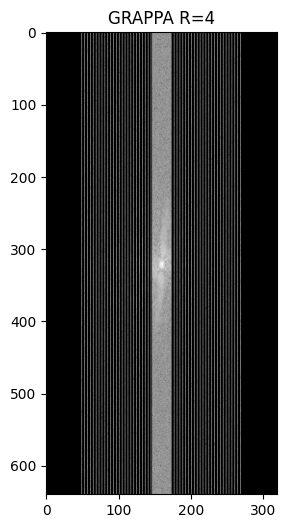

In [14]:
# Here select the mask type: with acceleration factor!

mask_func = create_mask_for_mask_type('equispaced', [0.08], [4]) 
masked_kspace_grappa4, mask, _ = T.apply_mask(kspace_torch, mask_func)

# Show GRAPPA MASK for R=4
slice_idx = 4
fig = plt.figure(figsize=(12,6))
plt.imshow(np.log(np.abs(fastmri.complex_abs(masked_kspace_grappa4).numpy()[3,:,:,:]) + 1e-9)[slice_idx], cmap='gray')
plt.title('GRAPPA R=4')
plt.savefig('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/figures/GRAPPA R=4.png')


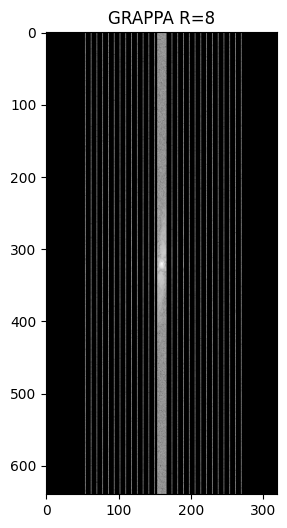

In [15]:
# Show GRAPPA MASK for R=8
mask_func = create_mask_for_mask_type('equispaced', [0.04], [8]) 
masked_kspace_grappa8, mask, _ = T.apply_mask(kspace_torch, mask_func)

slice_idx = 4
fig = plt.figure(figsize=(12,6))
plt.imshow(np.log(np.abs(fastmri.complex_abs(masked_kspace_grappa8).numpy()[3,:,:,:]) + 1e-9)[slice_idx], cmap='gray')
plt.title('GRAPPA R=8')
plt.savefig('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/figures/GRAPPA R=8.png')

SENSE UNDERSAMPLING MASKS

In [16]:
# Now, we can start looking at SENSE undersampling as used in the real world

def generate_array(shape, R, tensor_out):
    length = shape[-1]

    # Initialize an array of zeros
    array = np.zeros(length)

    # Determine the central index
    array[length // 2] = 1

    # Set every R-1'th sample to 1, starting from the central index
    for i in range(length // 2, length, R):
        array[i] = 1

    # Mirror the behavior to the first half of the array
    if length % 2 == 0:
        array[1:length // 2] = np.flip(array[length // 2 + 1:])
    else:
        array[:length // 2] = np.flip(array[length // 2 + 1:])

    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)

    return array


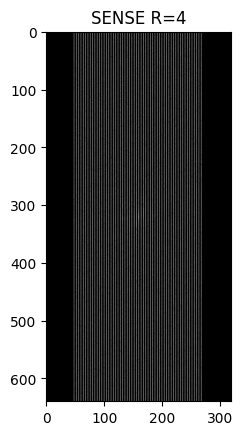

In [17]:
slice_kspace = kspace[10] # Choosing the 10-th slice of this volume

# SENSE type mask for R=4
mask = generate_array(slice_kspace.shape, 4, tensor_out=False)
masked_kspace_sense4 = slice_kspace * mask + 0.0 

plt.imshow(np.log(np.abs(masked_kspace_sense4[5]) + 1e-9), cmap='gray')
plt.title('SENSE R=4')
plt.savefig('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/figures/SENSE R=4.png')

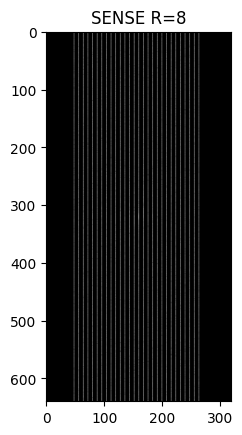

In [18]:
# SENSE type mask for R=8
mask = generate_array(slice_kspace.shape, 8, tensor_out=False)
masked_kspace_sense8 = slice_kspace * mask + 0.0 

plt.imshow(np.log(np.abs(masked_kspace_sense8[5]) + 1e-9), cmap='gray')
plt.title('SENSE R=8')
plt.savefig('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/figures/SENSE R=8.png')

CS UNDERSAMPLING MASKS

In [19]:
import scipy.io as sio

mat_file = sio.loadmat('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/fastMRI/sampling_profiles_CS.mat')
mat_file.keys()


dict_keys(['__header__', '__version__', '__globals__', 'm256_CS1_mask', 'm256_CS2_mask', 'm256_CS4_mask', 'm256_CS6_mask', 'm256_CS8_mask', 'm256_full_mask', 'm320_CS1_mask', 'm320_CS2_mask', 'm320_CS4_mask', 'm320_CS6_mask', 'm320_CS8_mask', 'm320_full_mask'])

In [20]:
# Now, we can start looking at CS undersampling as used in the real world

def closer_to_4_or_8(float):
    diff_4 = np.abs(float - 4)
    diff_8 = np.abs(float - 8)

    if diff_4 < diff_8:
        return int(4)
    elif diff_8 < diff_4:
        return int(8)

def generate_array(shape, R, mat_file, tensor_out):
    if R == 4:
        array = mat_file['m320_CS4_mask'].squeeze()
    elif R == 8:
        array = mat_file['m320_CS8_mask'].squeeze()
    else:
        raise ValueError('Unrecognized acceleration factor specified. Must be 4 or 8.')
    # Calculate padding needed to reach the desired length
    desired_length = shape[-1]
    padding_needed = desired_length - len(array)
    if padding_needed > 0:
        # Calculate padding width for symmetric padding
        padding_width = (padding_needed // 2, padding_needed - padding_needed // 2)
        # Pad the array symmetrically
        array = np.pad(array, padding_width, mode='symmetric')
    elif padding_needed < 0:
        # Calculate trimming indices for symmetric trimming
        trim_start = -padding_needed // 2
        trim_end = len(array) + padding_needed // 2
        # Trim the array symmetrically
        array = array[trim_start:trim_end]
    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)
    return array


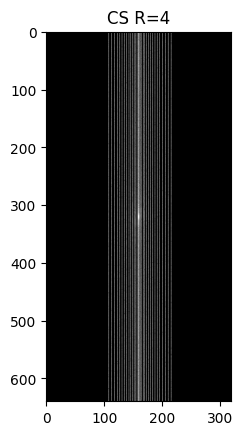

In [21]:
# CS type mask for R=4
mask = generate_array(slice_kspace.shape, closer_to_4_or_8(4.5), mat_file, tensor_out=False)
masked_kspace_CS4 = slice_kspace * mask + 0.0

plt.imshow(np.log(np.abs(masked_kspace_CS4[5]) + 1e-9), cmap='gray')
plt.title('CS R=4')
plt.savefig('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/figures/CS R=4.png')

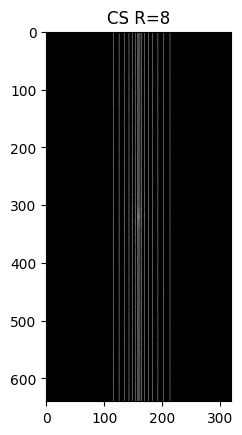

In [22]:
# CS type mask for R=8
mask = generate_array(slice_kspace.shape, closer_to_4_or_8(8.1), mat_file, tensor_out=False)
masked_kspace_CS8 = slice_kspace * mask + 0.0

plt.imshow(np.log(np.abs(masked_kspace_CS8[5]) + 1e-9), cmap='gray')
plt.title('CS R=8')
plt.savefig('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/figures/CS R=8.png')


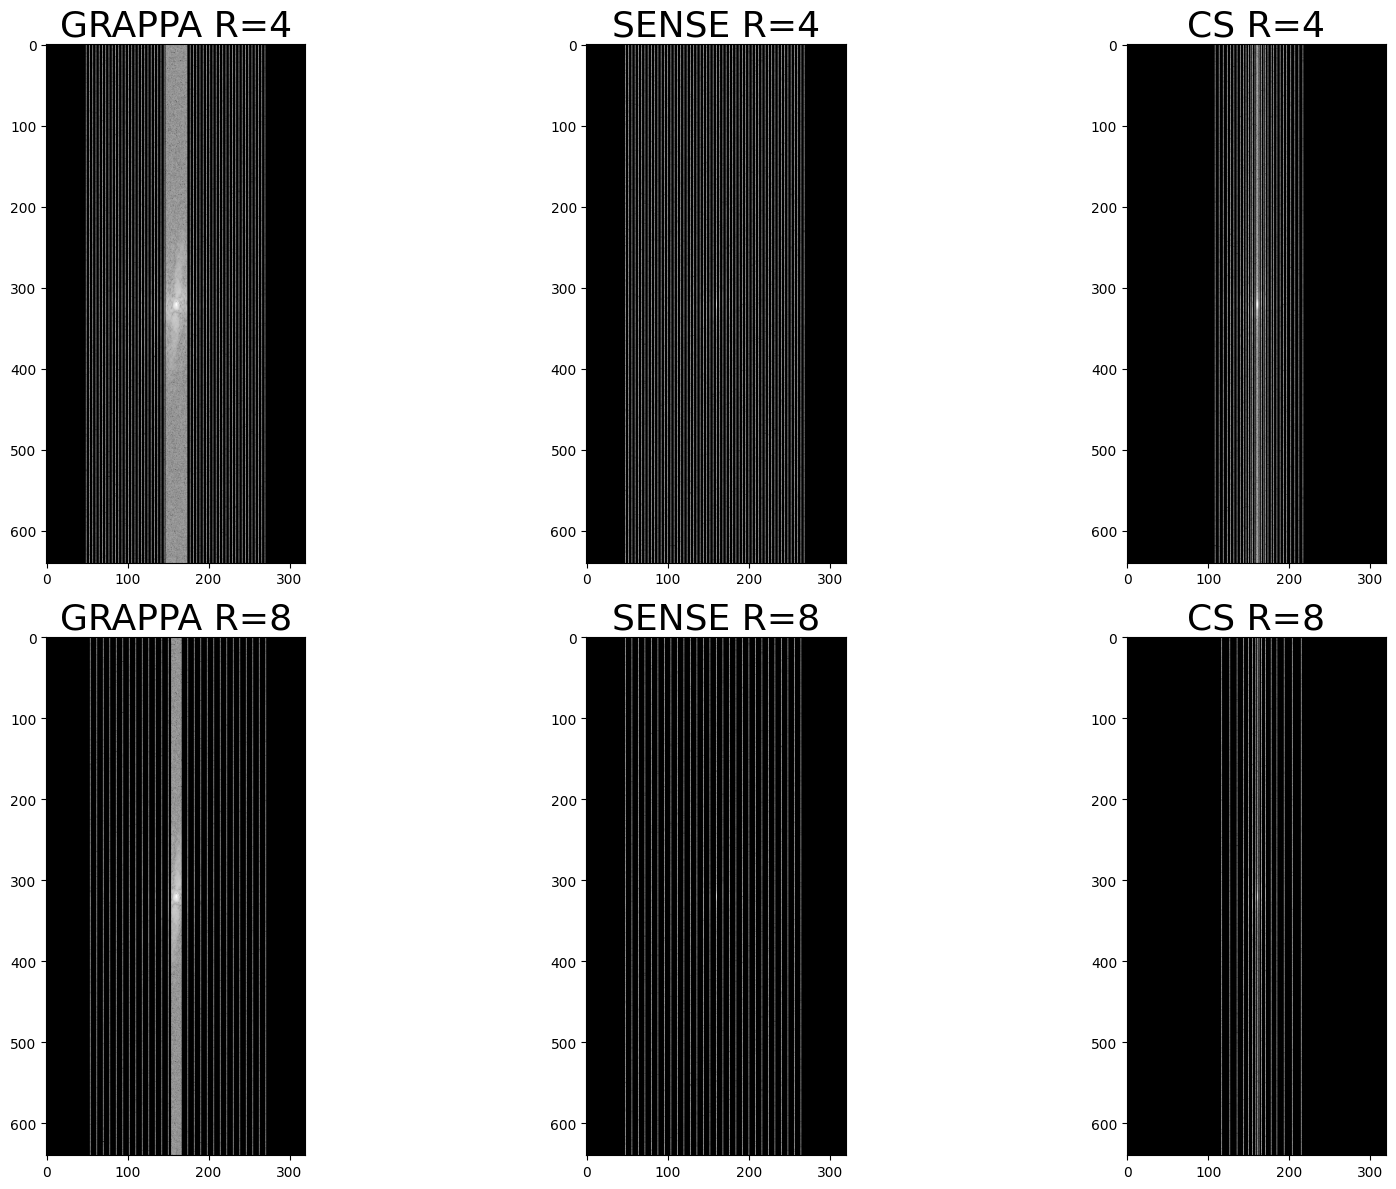

In [26]:

# Increase the font size of the titles
plt.rcParams['axes.titlesize'] = 26

fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Plot R=4 masks
axs[0, 0].imshow(np.log(np.abs(fastmri.complex_abs(masked_kspace_grappa4).numpy()[3,:,:,:]) + 1e-9)[slice_idx], cmap='gray')
axs[0, 0].set_title('GRAPPA R=4')

axs[0, 1].imshow(np.log(np.abs(masked_kspace_sense4[5]) + 1e-9), cmap='gray')
axs[0, 1].set_title('SENSE R=4')

axs[0, 2].imshow(np.log(np.abs(masked_kspace_CS4[5]) + 1e-9), cmap='gray')
axs[0, 2].set_title('CS R=4')

# Plot R=8 masks
axs[1, 0].imshow(np.log(np.abs(fastmri.complex_abs(masked_kspace_grappa8).numpy()[3,:,:,:]) + 1e-9)[slice_idx], cmap='gray')
axs[1, 0].set_title('GRAPPA R=8')

axs[1, 1].imshow(np.log(np.abs(masked_kspace_sense8[5]) + 1e-9), cmap='gray')
axs[1, 1].set_title('SENSE R=8')

axs[1, 2].imshow(np.log(np.abs(masked_kspace_CS8[5]) + 1e-9), cmap='gray')
axs[1, 2].set_title('CS R=8')

plt.tight_layout()
plt.savefig('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/figures/All_masks.png')
plt.show()